# Importing Libraries

In [1]:
import os
import cv2
from sklearn.utils import shuffle 
import seaborn as sn; sn.set(font_scale=1.2)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Loading Dataset

In [2]:
class_names = ['Benign cases','Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['train', 'test']
    output = []    
    for dataset in datasets:        
        images = []
        labels = []        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):                
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)                 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [00:06<00:00, 51.46it/s]


Loading test


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:01<00:00, 49.76it/s]


# Shuffle Data 

In [5]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploratory Data Analysis

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 876
Number of testing examples: 221
Each image is of size: (224, 224)


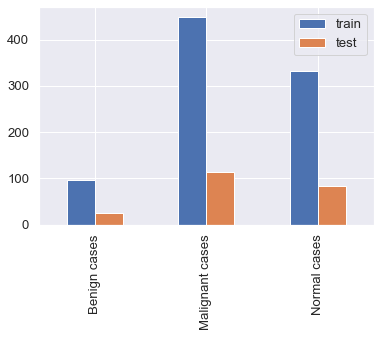

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()

plt.show()

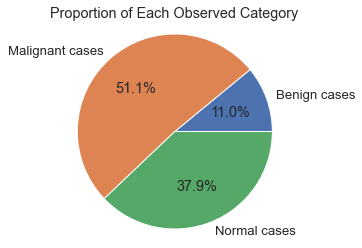

In [8]:
plt.pie(train_counts,
        explode=None, 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of Each Observed Category')
plt.show()

# Data Preprocessing

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Transfer Learning Feature Extraction -- VGG16

In [10]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

In [11]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [12]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

# Deep Learning Architecture

# 1. Define Network

In [13]:
import tensorflow as tf 
from tensorflow.keras.utils import plot_model

In [14]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (14, 14, 512)) 

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(3,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [15]:
new_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14, 14, 512)]     0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 32)         

# 2. Compile Network

In [16]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

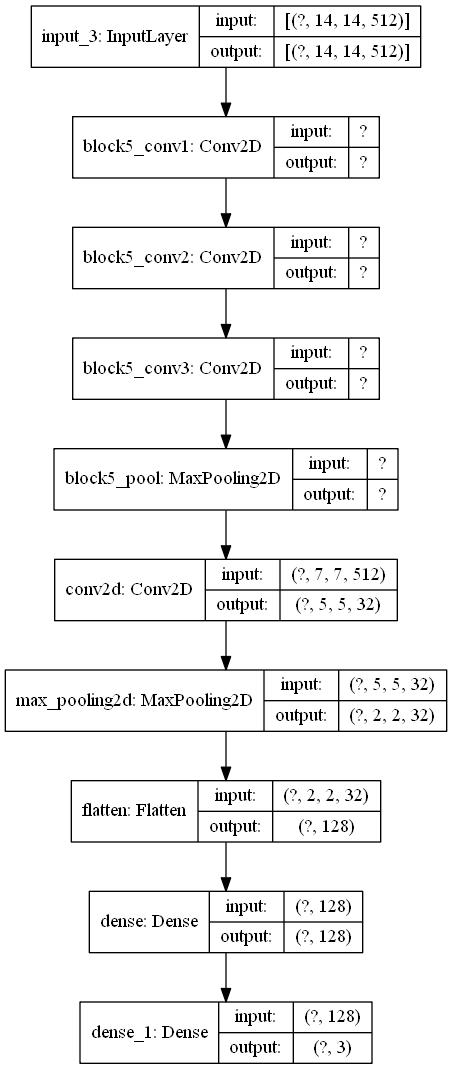

In [17]:
plot_model(new_model, 'Transfer Learning Feature Extraction.jpg', show_shapes = True)

# 3. Fit Network

In [18]:
history = new_model.fit(train_features, train_labels, batch_size=64, epochs=30, validation_split = 0.2)

Epoch 1/30
11/11 [==============================] - 67s 6s/step - loss: 1.3428 - accuracy: 0.4886 - val_loss: 1.8251 - val_accuracy: 0.3750
Epoch 2/30
11/11 [==============================] - 64s 6s/step - loss: 1.0683 - accuracy: 0.5486 - val_loss: 0.8406 - val_accuracy: 0.6932
Epoch 3/30
11/11 [==============================] - 66s 6s/step - loss: 0.6961 - accuracy: 0.7371 - val_loss: 0.6599 - val_accuracy: 0.7955
Epoch 4/30
11/11 [==============================] - 63s 6s/step - loss: 0.4835 - accuracy: 0.8400 - val_loss: 0.4309 - val_accuracy: 0.8295
Epoch 5/30
11/11 [==============================] - 63s 6s/step - loss: 0.3050 - accuracy: 0.8757 - val_loss: 0.3308 - val_accuracy: 0.8523
Epoch 6/30
11/11 [==============================] - 63s 6s/step - loss: 0.2414 - accuracy: 0.8971 - val_loss: 0.2997 - val_accuracy: 0.8636
Epoch 7/30
11/11 [==============================] - 65s 6s/step - loss: 0.2066 - accuracy: 0.9100 - val_loss: 0.2505 - val_accuracy: 0.8864
Epoch 8/30
11/11 [==

# 4.Evaluate Network

## 4.1. Classification Report

In [20]:
test_loss = new_model.evaluate(test_features, test_labels)

7/7 [==============================] - 5s 651ms/step - loss: 0.1032 - accuracy: 0.9593


In [21]:
test_loss

[0.10315921902656555, 0.959276020526886]

In [23]:
predictions = new_model.predict(test_features)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

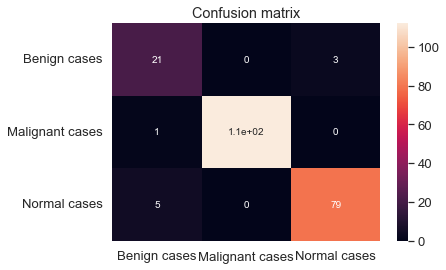

In [24]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report
print('Classification Report')

print(classification_report(test_labels,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       1.00      0.99      1.00       113
           2       0.96      0.94      0.95        84

    accuracy                           0.96       221
   macro avg       0.91      0.94      0.92       221
weighted avg       0.96      0.96      0.96       221



## 4.2. Plotting Loss and Accuracy Curve

Text(0.5, 1.0, 'Accuracy Curves for Transfer Learning Feature Extraction')

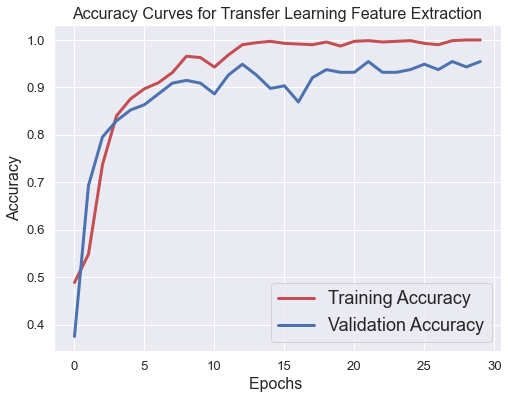

In [26]:
# Accuracy Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves for Transfer Learning Feature Extraction',fontsize=16)

Text(0.5, 1.0, 'Loss Curves for Transfer Learning Feature Extraction')

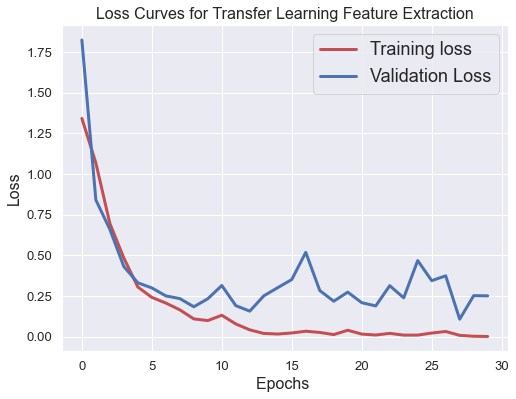

In [27]:
# Loss Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['loss'],'r',linewidth=3.0)

plt.plot(history.history['val_loss'],'b',linewidth=3.0)

plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves for Transfer Learning Feature Extraction',fontsize=16)

## 4.3. Evaluation

In [28]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(test_labels,pred_labels))
print('MSE:', metrics.mean_squared_error(test_labels,pred_labels))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels,pred_labels)))

MAE: 0.07692307692307693
MSE: 0.1493212669683258
RMSE: 0.3864211005733587


In [29]:
from sklearn.metrics import precision_score
print("Precision Score : ",precision_score(test_labels,pred_labels, average='weighted'))


from sklearn.metrics import recall_score
print("Recall Score : ",recall_score(test_labels,pred_labels,average='weighted'))


from sklearn.metrics import f1_score
print("f1_score : ",f1_score(test_labels,pred_labels,average='weighted'))

Precision Score :  0.9619615200676892
Recall Score :  0.9592760180995475
f1_score :  0.9602456601314315


##  4.4. Make Predictions

In [31]:
preds = new_model.predict(test_features)

print('shape of preds: ', preds.shape)

shape of preds:  (221, 3)


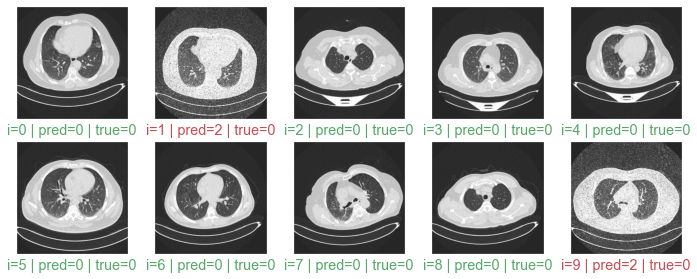

In [33]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(test_labels[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(test_images[start_index + i], cmap='binary')
plt.show()